# Corsair Data Analytics On Amazon Reviews

In [92]:
import numpy as np
import pandas as pd
import seaborn as sns

from collections import Counter
from wordcloud import WordCloud

from matplotlib import pyplot as plt
from pandarallel import pandarallel

from reviews.config import processed_data_dir

pandarallel.initialize(progress_bar=False, nb_workers=8)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


### Read Data

In [93]:
data_df = pd.read_json(processed_data_dir / "products_reviews.json.gz")

data_df["asin"] = data_df["asin"].astype("category")
data_df["text"] = data_df["text"].astype("string")
data_df["summary"] = data_df["summary"].astype("string")
data_df["overall"] = data_df["overall"].astype("category")
data_df["brand"] = data_df["brand"].astype("category")
data_df["category"] = data_df["category"].astype("category")
data_df["description"] = data_df["description"].astype("string")
data_df["title"] = data_df["title"].astype("string")

data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21922 entries, 0 to 21921
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   asin             21922 non-null  category      
 1   overall          21922 non-null  category      
 2   summary          21922 non-null  string        
 3   text             21922 non-null  string        
 4   timestamp        21922 non-null  datetime64[ns]
 5   vote             21922 non-null  int64         
 6   brand            21911 non-null  category      
 7   category         21922 non-null  category      
 8   description      21368 non-null  string        
 9   imageURLHighRes  18019 non-null  object        
 10  price            21922 non-null  float64       
 11  title            21922 non-null  string        
dtypes: category(4), datetime64[ns](1), float64(1), int64(1), object(1), string(4)
memory usage: 1.7+ MB


In [94]:
data_df.head(5)

,asin,overall,summary,text,timestamp,vote,brand,category,description,imageURLHighRes,price,title
0,B00C53ANDO,5,Five Stars,perfect,2018-01-16,0,a-tech components,Memory,4GB DDR3 PC3-12800 LAPTOP Memory Module (204-p...,None,19.99,4GB DDR3 PC3-12800 LAPTOP Memory Module (204-p...
1,B009COAEUG,5,The air flow on this unit is adequate to compl...,"Mine is installed in a closet, pulling air fro...",2016-01-09,0,ac infinity,Fans & Cooling,Product Description The ultra-quiet fan system...,https://images-na.ssl-images-amazon.com/images...,24.99,"AC Infinity AIRPLATE S1, Quiet Cooling Fan Sys..."
2,B00KTXI5D2,5,Had a noisy fan in a power inverter. I ...,Had a noisy fan in a power inverter. I replace...,2016-01-06,0,ace seller,Fans & Cooling,Item: Brushless DC Cooling Fan Blower 5015S...,https://images-na.ssl-images-amazon.com/images...,5.25,Brushless DC Cooling Fan Blower 5015S 5V 0.1-0.3A
3,B017DYKCNA,5,... i put in my sons computer and its really g...,the chip i put in my sons computer and its rea...,2017-09-24,0,amd,CPU Processors,"AMD FX 8-Core Processor, Unlocked, Black Editi...",https://images-na.ssl-images-amazon.com/images...,4.59,AMD FD8350FRHKBOX FX-8350 FX-Series 8-Core Bl...
4,B006WAGG14,5,Can't go wrong with Crucial,"Quality memory from a ""name brand"" supplier. B...",2016-07-27,0,ballistix,Memory,BLS4G3D1609DS1S00 is a single 4GB DDR3 module ...,https://images-na.ssl-images-amazon.com/images...,2.54,Ballistix Sport 4GB Single DDR3 1600 MT/s (PC3...


### Select Corsair specific Data

In [95]:
corsair_df = data_df[data_df['brand'] == 'corsair']
corsair_df.head(5)

,asin,overall,summary,text,timestamp,vote,brand,category,description,imageURLHighRes,price,title
9,B0029U2YSA,5,Happy!,Works easily to import VHS and 8mm home movies...,2016-04-18,0,corsair,TV Tuner & Capture Cards,"Digitize video from a VCR, camcorder and other...",https://images-na.ssl-images-amazon.com/images...,3.09,"Elgato Video Capture - Digitise Video for Mac,..."
11,B0092ML0MY,5,Five Stars,lots of power whisper quiet,2015-11-13,0,corsair,Power Supplies,The Corsair Builder Series of PSUs are designe...,https://images-na.ssl-images-amazon.com/images...,4.16,Corsair CX Series 500 Watt 80 Plus Bronze Cert...
15,B00PC9H6TM,5,Ordered for my Ryzen build follow AMD's mid la...,Ordered for my Ryzen build follow AMD's mid la...,2018-04-20,0,corsair,Memory,Vengeance LPX memory is designed for high-perf...,https://images-na.ssl-images-amazon.com/images...,4.83,Corsair Vengeance LPX 32GB (4 x 8GB) DDR4 DRAM...
16,B00F6S10KK,5,Would Buy Again,"Great Fans Look Awesome On My Case , Arrived O...",2015-12-01,0,corsair,Fans & Cooling,Superior cooling performance and LED illuminat...,https://images-na.ssl-images-amazon.com/images...,2.54,Corsair Air Series AF120 LED Quiet Edition Hig...
20,B019954Y2Q,5,Five Stars,Works perfectly as it said It would.,2016-05-12,0,corsair,Fans & Cooling,Hydro Series H80i v2 is an all-in-one liquid C...,https://images-na.ssl-images-amazon.com/images...,4.02,CORSAIR Hydro Series H80i v2 AIO Liquid CPU Co...


### Number of Products Reviewed and total Number of Reviews

In [214]:
corsair_df["asin"] = corsair_df["asin"].astype("string").astype("category")

'Number of total Reviews: {}, Number of total Products Reviwed: {}, Mean Number of Reviews Per Product: {}' \
    .format(len(corsair_df), len(corsair_df["asin"].unique()), corsair_df['asin'].value_counts().mean())


/tmp/ipykernel_726897/2907760267.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



'Number of total Reviews: 2455, Number of total Products Reviwed: 123, Mean Number of Reviews Per Product: 19.959349593495936'

### Reviews Over Time 
- Looking the numner of reviews over the years we can see the raising in the interest of people in ~2012 to ~2016 then decreasing until 2018
- Looking at how many reviews they have on average per week/month telling us how much the customers are active

In [55]:
period = 'M'
corsair_df["period"] = corsair_df["timestamp"].dt.to_period(period)
corsair_df["period"] = corsair_df["period"].dt.to_timestamp()

x = pd.DataFrame(corsair_df["period"].value_counts().reset_index().rename(columns={'index':'period', "period": "count"}))

import plotly.express as px

px.bar(x, x="period", y="count", color_discrete_sequence=['gray'])

/tmp/ipykernel_726897/1618800006.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_726897/1618800006.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



### Reviews Ratings (how satisfied customers feel with our brand products)

Average Rating: 4.53


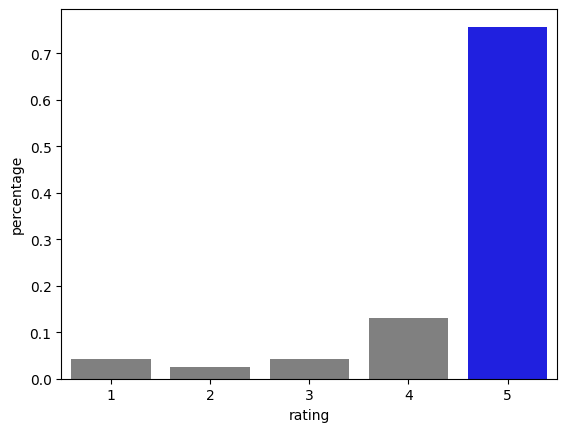

In [10]:
rating_df = corsair_df["overall"] \
    .value_counts(normalize=True) \
    .reset_index() \
    .rename(columns={'index':'rating', 'overall':'percentage'})

rating_df = pd.DataFrame(rating_df)
rating_df["rating"] = rating_df["rating"].astype("category")
rating_df['color'] = rating_df["rating"].apply(
    lambda x: "blue" if x == 5 else "gray"
)

barplot_palette = pd.DataFrame(rating_df.groupby(['rating', 'percentage'])['color'] \
    .value_counts()) \
    .rename(columns={'color':'count2'}) \
    .reset_index() \
    .sort_values(by='percentage')['color']

sns.barplot(rating_df, y='percentage', x='rating', palette=barplot_palette)


print("Average Rating: {:,.2f}".format(corsair_df["overall"].astype("float").mean()))

### Most Reviewed Categories (the main categories that our brand deals with)

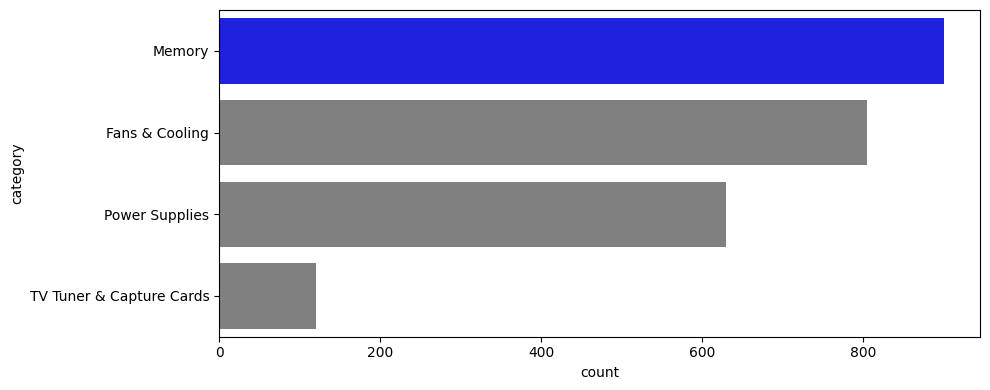

In [11]:
fig = plt.figure(figsize=(10, 4))

category_df = pd.DataFrame(corsair_df['category'] \
    .value_counts()) \
    .reset_index() \
    .rename(columns={'index':'category', 'category':'count'})

category_df[category_df["count"] <= 0] = np.nan
category_df.dropna(inplace=True)
category_df["category"] = category_df["category"].astype("category")
category_df["count"] = category_df["count"].astype("int")


category_df["color"] = category_df["count"].apply(
    lambda x: "blue" if x == category_df["count"].max() else "gray"
)

barplot_palette = pd.DataFrame(category_df.groupby(['category', 'count'])['color'] \
    .value_counts()) \
    .rename(columns={'color':'count2'}) \
    .reset_index() \
    .sort_values(by='count', ascending=False)['color']

ax = sns.barplot(category_df, x='count', y='category', 
                order=category_df.sort_values(by='count', ascending=False)["category"], palette=barplot_palette)
fig.tight_layout()

plt.legend([],[], frameon=False)

### Compare Rating with Price (to see customer satisfaction based on product price)
- there seems to be no correlation

/tmp/ipykernel_726897/2591443561.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



0.04633935563746454


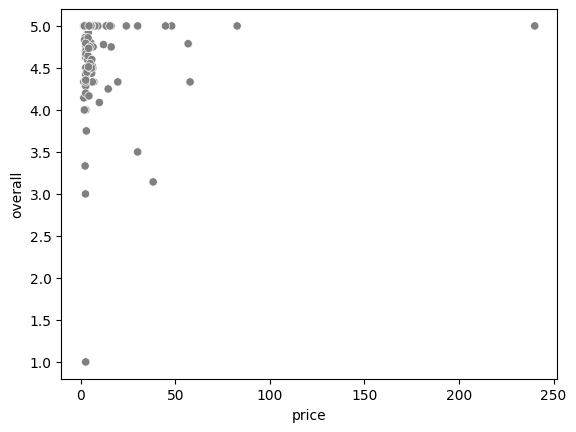

In [213]:
x = corsair_df.groupby("asin")['overall'].mean().reset_index()
y = corsair_df[["asin", "price"]].drop_duplicates()
rp_df = pd.merge(x, y, on="asin")
rp_df['colors'] = ['gray' for item in rp_df['overall']]

sns.scatterplot(rp_df, x="price", y="overall", hue='colors', palette=['gray'], legend=False)


from scipy.stats import pearsonr
corr, _ = pearsonr(rp_df['price'], rp_df['overall'])
print(corr)

### Number of Reviews per Price (telling us at what price people are more willing to buy)

In [13]:
price_categories = pd.CategoricalDtype(
    categories=[
        "Under \$25",
        "\$25 to \$50",
        "\$50 to \$100",
        "\$100 to \$200",
        "\$200 & Above",
    ],
    ordered=True,
)

corsair_df["price"] = corsair_df["price"].apply(
    lambda x: "Under \$25"
    if x < 25
    else (
        "\$25 to \$50"
        if x < 50
        else (
            "\$50 to \$100"
            if x < 100
            else ("\$100 to \$200" if x < 200 else "\$200 & Above")
        )
    )
)
corsair_df["price"] = corsair_df["price"].astype(price_categories)

/tmp/ipykernel_726897/1333658384.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_726897/1333658384.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



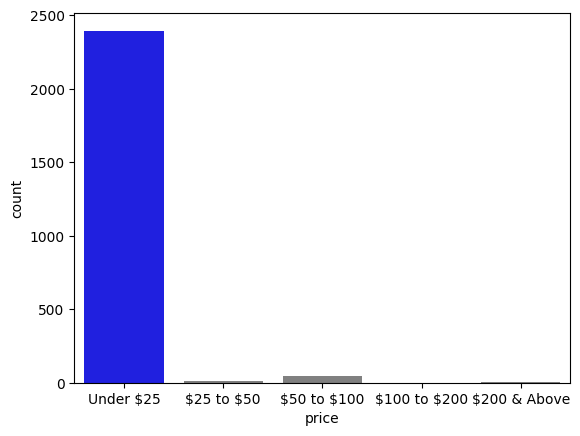

In [14]:
price_palette = []
categories=[
    "Under \$25",
    "\$25 to \$50",
    "\$50 to \$100",
    "\$100 to \$200",
    "\$200 & Above",
]
for x in categories:
    if x == "Under \$25":
        price_palette.append('blue')
    else:
        price_palette.append('gray')

ax = sns.countplot(corsair_df, x='price', palette=price_palette)
fig.tight_layout()

### Corsairs' competitors
- Most Reviewed Brands of the Memory Category
- Most Reviewed Brands of the Fans & Cooling Category
- Most Reviewed Brands of the Power Supplies Category
- Most Reviewed Brands of the TV Tuner & Capture Cards Category

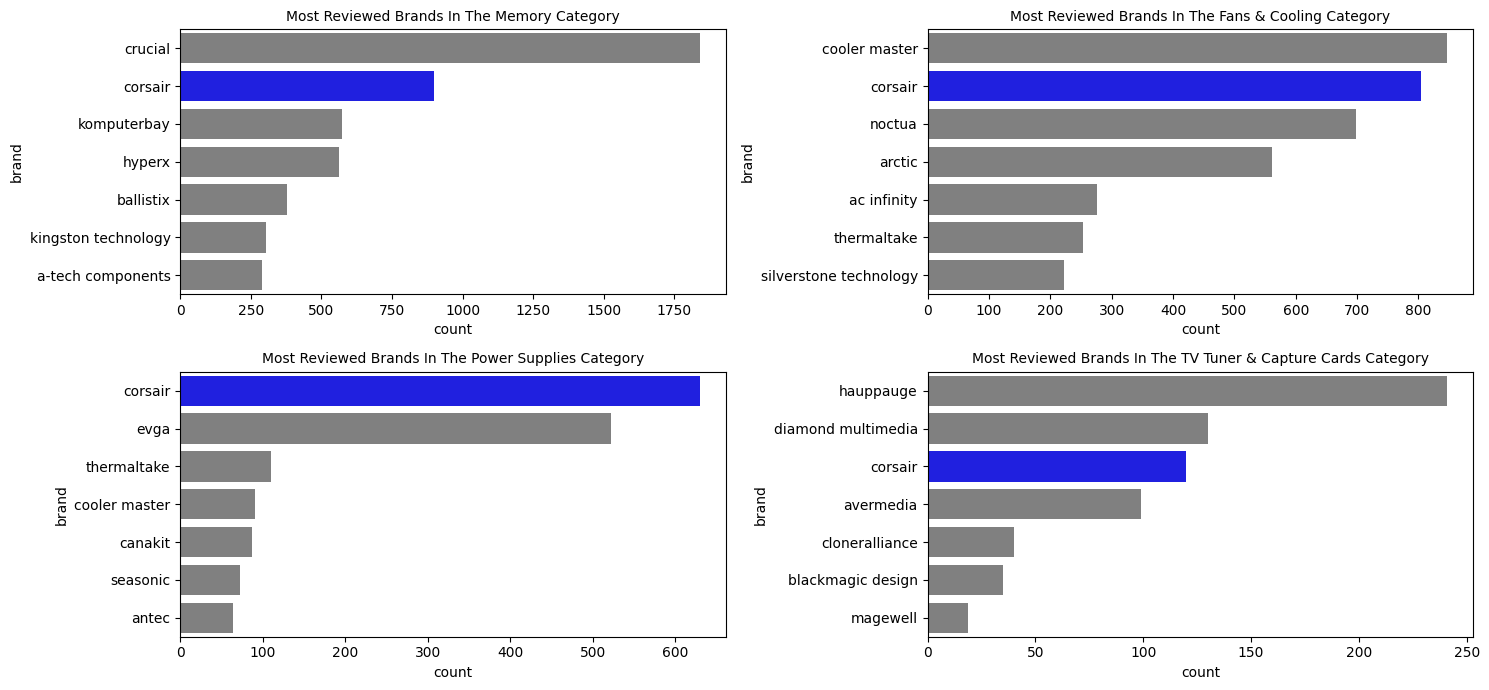

In [15]:
def competitors_by_category(data_df, category, ax):
    category_df = data_df[data_df['category'] == category]
    mc_category_brands_df = pd.DataFrame(Counter(category_df["brand"].tolist()).most_common(7)).reset_index().rename(columns={0:'brand', 1:'count'})

    mc_category_brands_df['color'] = mc_category_brands_df["brand"].apply(
        lambda x: "blue" if x == 'corsair' else "gray"
    )

    barplot_palette = pd.DataFrame(mc_category_brands_df.groupby(['brand', 'count'])['color'] \
        .value_counts()) \
        .rename(columns={'color':'count2'}) \
        .reset_index() \
        .sort_values(by='count', ascending=False)['color']

    plot = sns.barplot(mc_category_brands_df, x='count', y='brand',
                    order=mc_category_brands_df.sort_values(by='count', ascending=False)["brand"], palette=barplot_palette, ax=ax)
    plot.set_title(f'Most Reviewed Brands In The {category} Category', fontsize = 10)
    return plot

fig, axes = plt.subplots(2, 2, figsize=(15, 7))
axes = axes.flatten()
competitors_by_category(data_df, 'Memory', axes[0])
competitors_by_category(data_df, 'Fans & Cooling', axes[1])
competitors_by_category(data_df, 'Power Supplies', axes[2])
competitors_by_category(data_df, 'TV Tuner & Capture Cards', axes[3])
fig.tight_layout()

### Top 30 Most Common Votes (we can see how people usually don't vote on reviews or very few do)

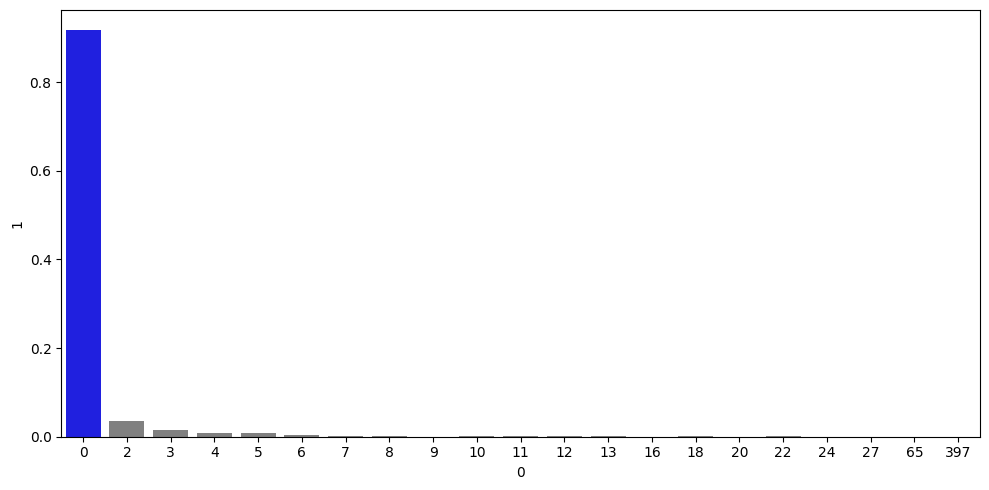

In [42]:
vote_df = pd.DataFrame(Counter(corsair_df['vote'].tolist()).most_common(30))
vote_df[1] = vote_df[1] / vote_df[1].sum()

vote_df["color"] = vote_df[1].apply(
    lambda x: "blue" if x == vote_df[1].max() else "gray"
)

fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(x=vote_df[0], y=vote_df[1], ax=ax, palette=vote_df["color"])
fig.tight_layout()

### Review Summary & Text

##### Summary

In [17]:
text_lengths = corsair_df["summary"].str.len()
mean_length = np.round(np.mean(text_lengths))
print("Mean Review Summary Length:", mean_length, "characters\n")

print("Some Review Summary Examples:\n")

k = 5
for x in corsair_df["summary"]:
    if k < 0:
        break
    else:
        print(x + '\n')
        k = k - 1

Mean Review Summary Length: 26.0 characters

Some Review Summary Examples:

Happy!

Five Stars

Ordered for my Ryzen build follow AMD's mid launch release ...

Would Buy Again

Five Stars

The Hot running Power Supply



/home/lfx/Desktop/amazon-reviews/venv/lib/python3.10/site-packages/seaborn/distributions.py:499: FutureWarning:

In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)

/home/lfx/Desktop/amazon-reviews/venv/lib/python3.10/site-packages/seaborn/distributions.py:500: FutureWarning:

In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)



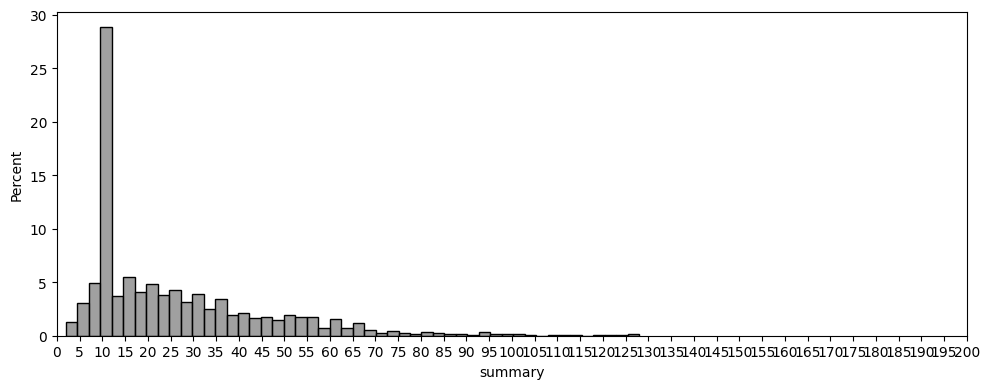

In [47]:
fig, ax = plt.subplots(figsize=(10, 4))
sns.histplot(x=corsair_df["summary"].str.len(), stat="percent", bins=50, ax=ax, color='gray')

ax.set_xlim([0, 200])
ax.set_xticks(range(0, 205, 5))
fig.tight_layout()

##### Text

In [19]:
text_lengths = corsair_df["text"].str.len()
mean_length = np.round(np.mean(text_lengths))
print("Mean Review Text Length:", mean_length, "characters\n")

print("Some Review Text Examples:\n")

k = 5
for x in corsair_df["text"]:
    if k < 0:
        break
    else:
        print(x + '\n')
        k = k - 1

Mean Review Text Length: 278.0 characters

Some Review Text Examples:

Works easily to import VHS and 8mm home movies to my Mac. I'm very happy to feel secure knowing my videos are preserved.

lots of power whisper quiet

Ordered for my Ryzen build follow AMD's mid launch release, current bios won't get it up to full speed but newer bios do.

Great Fans Look Awesome On My Case , Arrived On Time And Were very easy to install

Works perfectly as it said It would.

Gives you the amount of power you need, but the fan starts only when this unit is really hot! Do not understand why the design criteria was like that. Why let a 1000 watt power supply run that hot before turning the cooling fan on? I'm planning to open the power supply and try to lower the setting where the fan turns on, Now it's around 50 degree Celsius I will try to set it at 30 degrees Celsius.
Other the the temp issue, you can buy this power supply.



/home/lfx/Desktop/amazon-reviews/venv/lib/python3.10/site-packages/seaborn/distributions.py:499: FutureWarning:

In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)

/home/lfx/Desktop/amazon-reviews/venv/lib/python3.10/site-packages/seaborn/distributions.py:500: FutureWarning:

In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)



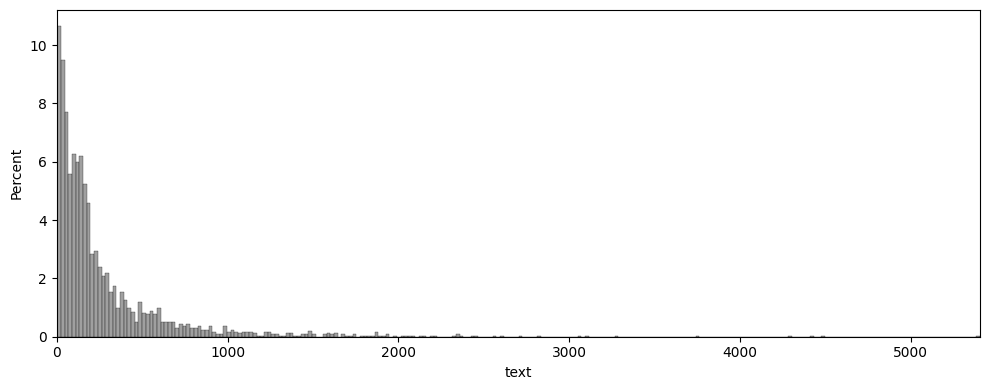

In [45]:
fig, ax = plt.subplots(figsize=(10, 4))
sns.histplot(text_lengths, stat="percent", bins=250, ax=ax, color='gray')
ax.set_xlim([0, np.max(text_lengths)])
fig.tight_layout()